In [1]:
import requests
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import numpy as np
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import os
import sys
import inspect
%matplotlib inline

In [2]:
file_path = os.path.realpath('tg_data.ipynb')
path = os.path.dirname(file_path)

In [3]:
path

'C:\\Users\\user\\Desktop\\анализ данных\\pet_project'

In [4]:
sns.set(
    font_scale=2,
    style="whitegrid",
    rc={'figure.figsize': (40, 14)}
)

In [5]:
# credentials
path_to_credential = 'pet-project-405417-4c86b1cb6dd6.json'
# что за таблица
table_name_1 = 'order_leads'
table_name_2 = 'invoices'
table_name_3 = 'sales_team'

In [6]:
scope = ['https://spreadsheets.google.com/feeds',
         'https://www.googleapis.com/auth/drive']

In [7]:
credentials = ServiceAccountCredentials.from_json_keyfile_name(path_to_credential, scope)
gs = gspread.authorize(credentials)

In [8]:
# откроем таблицы
work_sheet_1 = gs.open(table_name_1)
work_sheet_2 = gs.open(table_name_2)
work_sheet_3 = gs.open(table_name_3)

In [9]:
# возьмём 1 лист
sheet1 = work_sheet_1.sheet1
sheet2 = work_sheet_2.sheet1
sheet3 = work_sheet_3.sheet1

In [10]:
# данные в формате list
data_1 = sheet1.get_all_values()
data_2 = sheet2.get_all_values()
data_3 = sheet3.get_all_values()

In [11]:
# заголовки
headers_1 = data_1.pop(0)
headers_2 = data_2.pop(0)
headers_3 = data_3.pop(0)

In [12]:
# дф с данными таблицы
order_leads = pd.DataFrame(data_1, columns=headers_1)
invoices = pd.DataFrame(data_2, columns=headers_2)
sales_team = pd.DataFrame(data_3, columns=headers_3)

In [13]:
# изменим тип данных на дату
order_leads['Date'] = pd.to_datetime(order_leads.Date)

In [14]:
# переименуем столбцы для удобства
order_leads = order_leads.rename(columns={'Order Id': 'Order_Id',
                                          'Company Id': 'Company_Id',
                                          'Company Name': 'Company_Name',
                                          'Order Value': 'Order_Value'})

sales_team = sales_team.rename(columns={'Company Name': 'Company_Name',
                                        'Company Id'  : 'Company_Id',
                                        'Sales Rep'   : 'Sales_Rep',
                                        'Sales Rep Id': 'Sales_Rep_Id'})

In [15]:
order_leads['Order_Value'] = order_leads['Order_Value'].astype(float)
order_leads['Converted'] = order_leads['Converted'].astype(float)
invoices['Meal Price'] = invoices['Meal Price'].astype(float)

In [16]:
# замёрджим дф с командой продаж и дф с продажами
order_leads_with_team_data = order_leads.merge(sales_team, how='left', on=['Company_Name', 'Company_Id'])

In [17]:
# продавцы по cr
cr = order_leads_with_team_data.groupby('Sales_Rep', as_index=False) \
    .agg({'Converted': 'mean'}) \
    .sort_values('Converted')\
    .rename(columns = {'Converted': 'CR'})

In [18]:
# 10 лучших по cr продавцов
top_cr = cr.tail(10)
top_cr

,Sales_Rep,CR
346,Nick Allen,0.298507
192,Jennifer Peck,0.304348
468,Thomas Lindsey,0.304348
187,Jason Miller,0.307692
455,Teddy Cook,0.315789
225,Jose Gaines,0.326087
249,Katie Rodriquez,0.333333
466,Thomas Fortner,0.352941
438,Sierra Garcia,0.363636
151,Ginger Wright,0.368421


C:\Users\user\AppData\Local\Temp\ipykernel_12464\3175257555.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(top_cr.Sales_Rep, rotation=45)


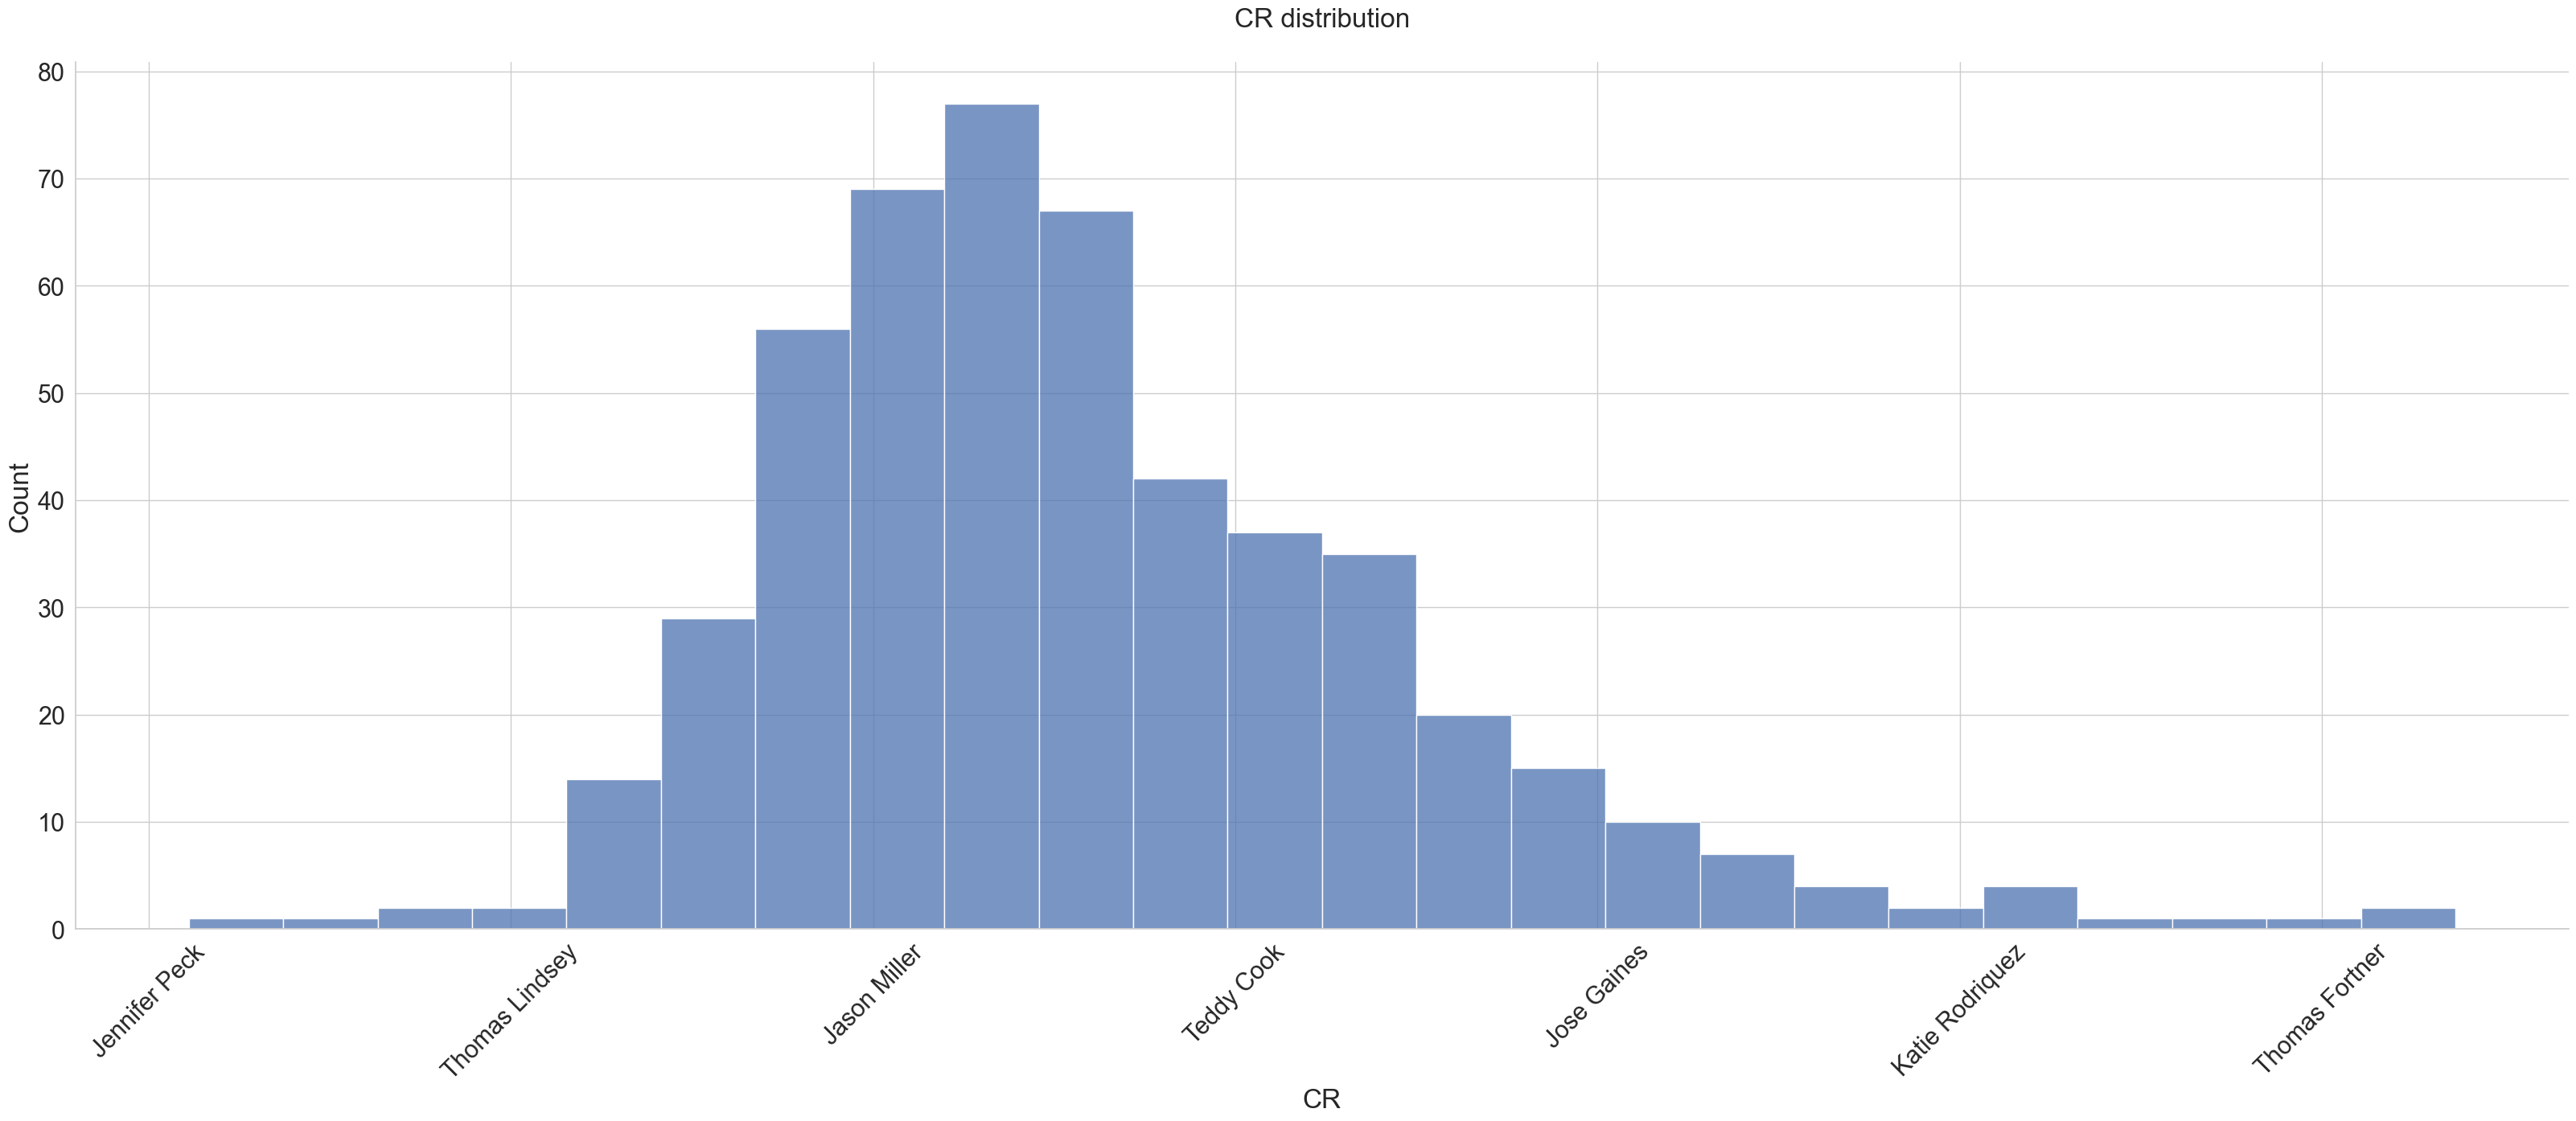

In [19]:
# распределение CR
ax = sns.histplot(cr.CR, kde=False)
ax.set_xticklabels(top_cr.Sales_Rep, rotation=45)
ax.set_title('CR distribution\n')
sns.despine()

fig = ax.get_figure()

fig.savefig(path+r"\cr_dist.pdf")

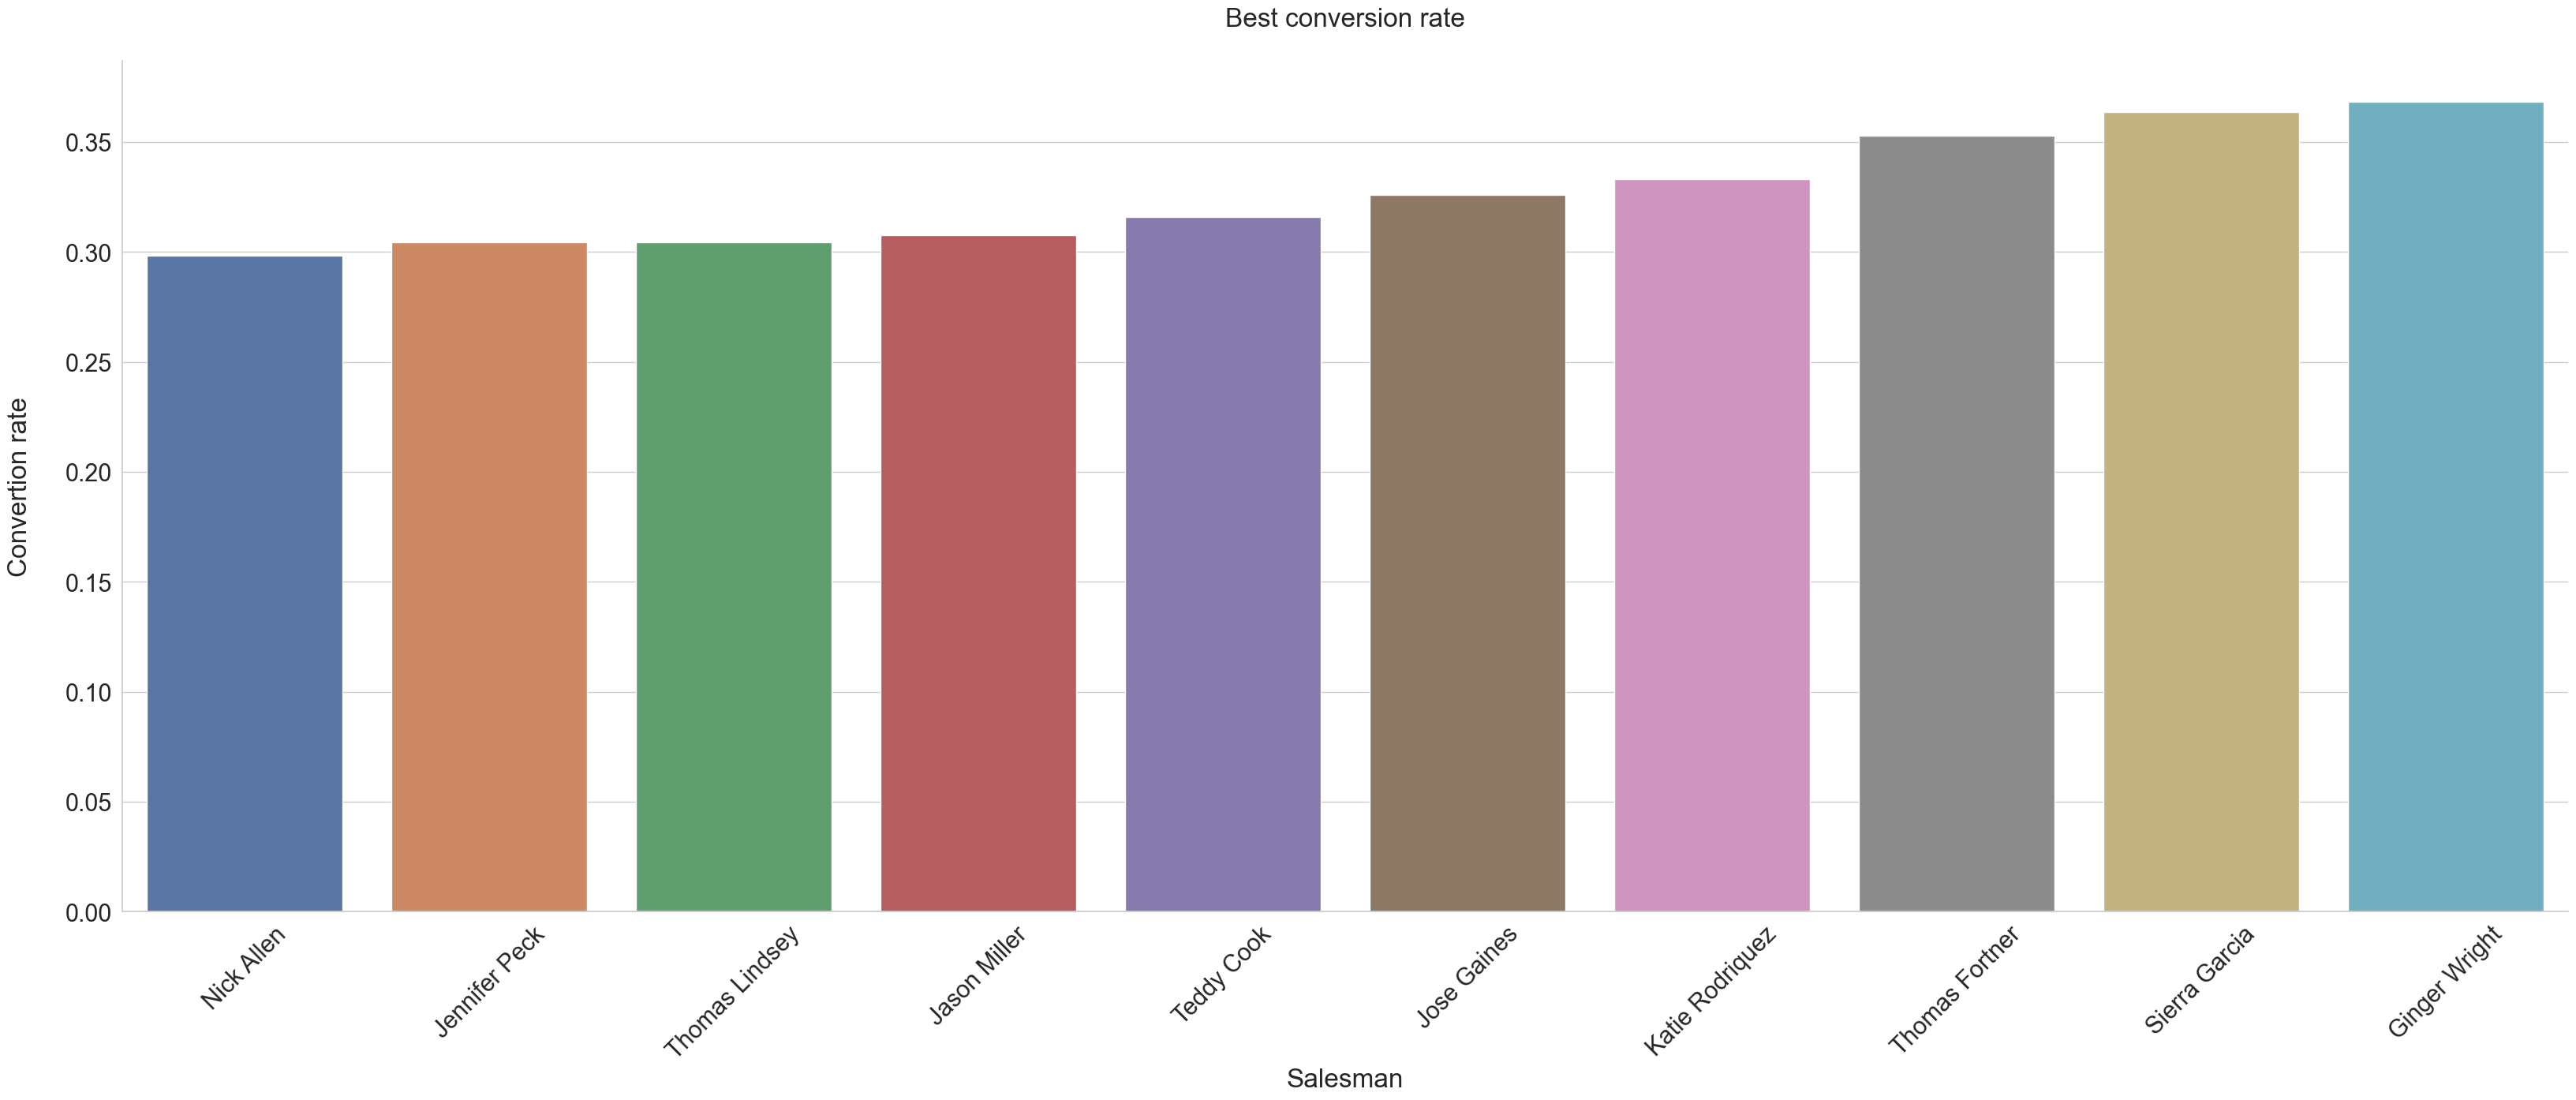

In [20]:
ax = sns.barplot(data=top_cr, y='CR', x='Sales_Rep')
ax.set_xticklabels(top_cr.Sales_Rep, rotation=45)
ax.set_title('Best conversion rate\n')
ax.set_ylabel('Convertion rate\n')
ax.set_xlabel('Salesman')
sns.despine()

fig = ax.get_figure()
fig.savefig(path+r'\best_salesman.pdf')


In [21]:
# График CR по дням
cr_by_day = order_leads.groupby(['Date']) \
    .agg({'Converted': 'mean'}) \
    .rename(columns={'Converted': 'CR'}) \
    .sort_values('Date')

<Axes: xlabel='Date'>

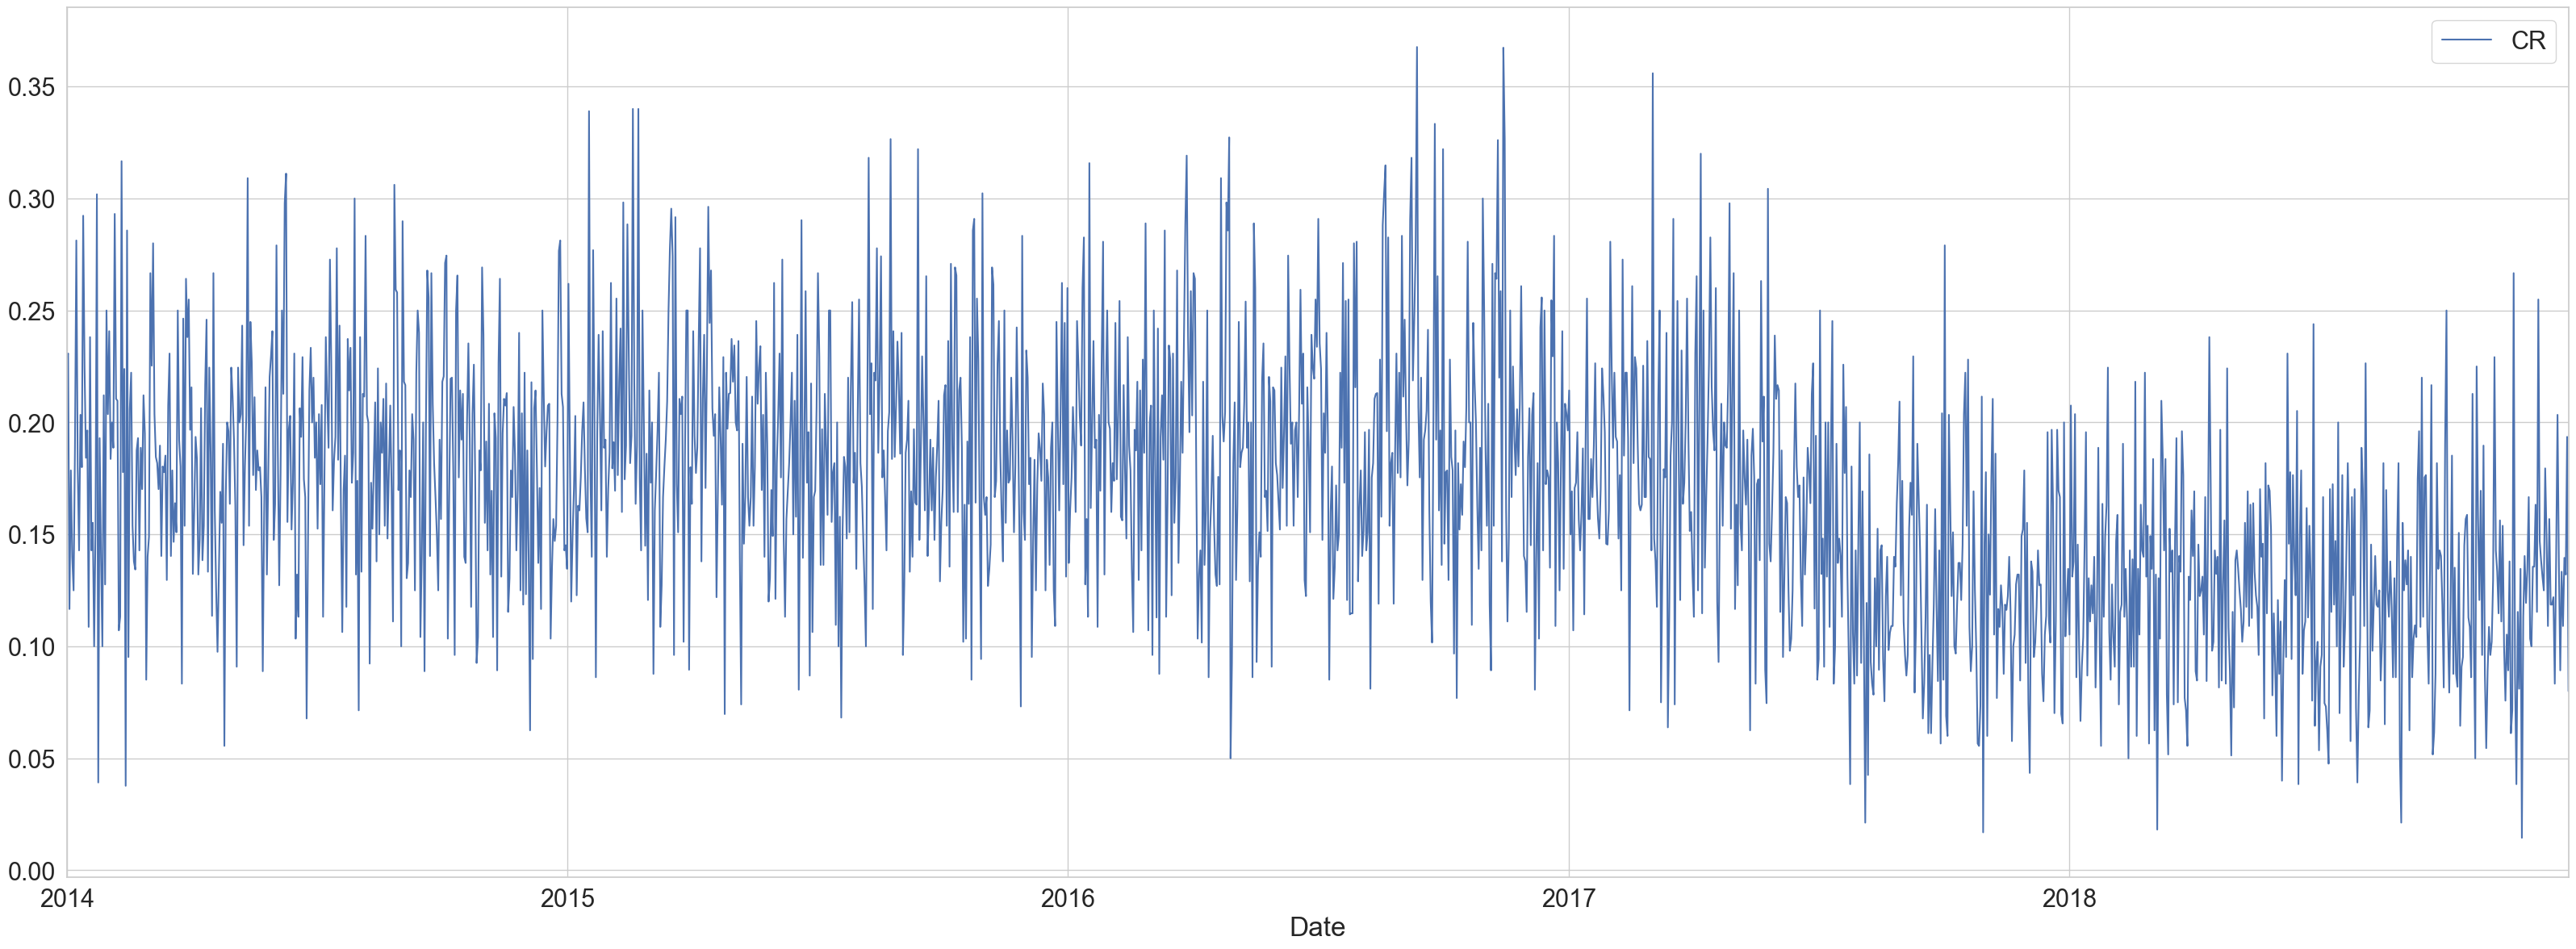

In [22]:
# график трудно читается
# сгладим углы, взяв скользящее среднее по данным
cr_by_day.plot()

In [23]:
cr_by_day_rolling = cr_by_day.rolling(30).mean()

C:\Users\user\AppData\Local\Temp\ipykernel_12464\802288763.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  cr_graph.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])


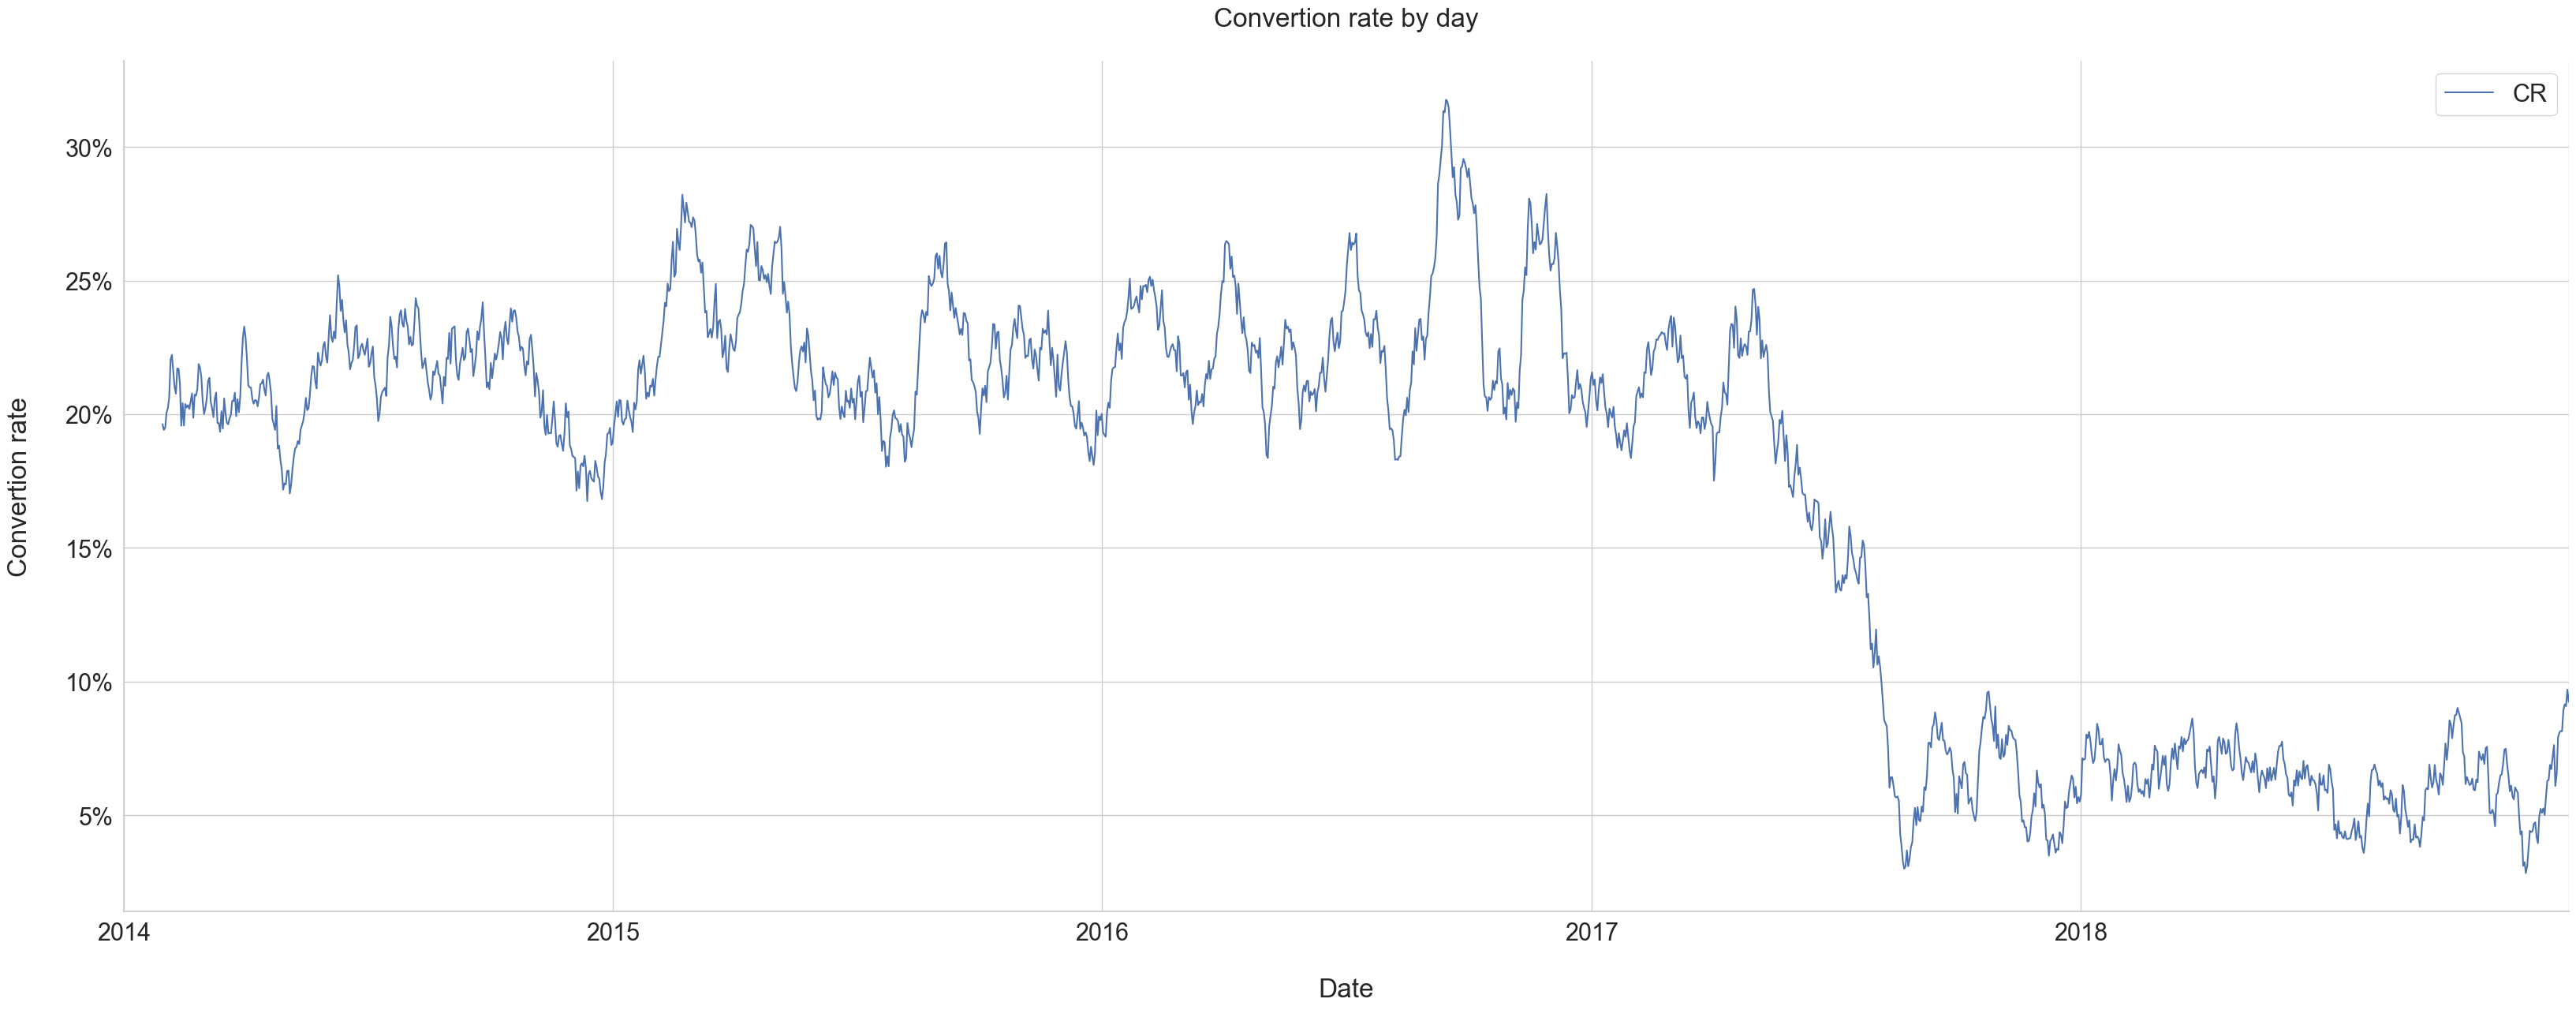

In [24]:
cr_graph = cr_by_day_rolling.plot()
cr_graph.set_title('Convertion rate by day\n')
cr_graph.set_ylabel('Convertion rate\n')
cr_graph.set_xlabel('\nDate')
cr_graph.set_yticklabels(['{:.0%}'.format(n) for n in ax.get_yticks()])
sns.despine()

fig = cr_graph.get_figure()
fig.savefig(path+r'\cr_by_day.pdf')

In [25]:
# 10 лучших по cr продавцов
top_cr

,Sales_Rep,CR
346,Nick Allen,0.298507
192,Jennifer Peck,0.304348
468,Thomas Lindsey,0.304348
187,Jason Miller,0.307692
455,Teddy Cook,0.315789
225,Jose Gaines,0.326087
249,Katie Rodriquez,0.333333
466,Thomas Fortner,0.352941
438,Sierra Garcia,0.363636
151,Ginger Wright,0.368421


In [26]:
# таблица с лучшими продавцами по cr
with pd.ExcelWriter(path+r'\output.xlsx') as writer:  
    top_cr.to_excel(writer, sheet_name='Sheet_name_1')

In [27]:
# отправим файлы в тг чат
today = datetime.date.today()

In [28]:
import requests
token='6842801376:AAGdF7Trdc0P7pfspKMOEYwQsZdqFlJ_YTo'
chat_id = 860144751
filename_1 = path + r"\best_salesman.pdf"
filename_2 = path + r"\cr_by_day.pdf"
filename_3 = path + r"\cr_dist.pdf"
filename_4 = path + r"\output.xlsx"
media = [filename_1, filename_2, filename_3, filename_4]

def send_document(filename, token, chat_id, today = datetime.date.today()):
    url = 'https://api.telegram.org/bot{}/sendDocument'.format(token)
    data = {'chat_id': chat_id, 'caption': f'Отчеты, отчетики, графики, графики и отчётики мои. {today}'}
    files = filename
    for x in filename:
        with open(x, 'rb') as f:
            files = {'document': f}
            response = requests.post(url, data=data, files=files)
            print(response.json())
send_document(media, token, chat_id)

{'ok': True, 'result': {'message_id': 55, 'from': {'id': 6842801376, 'is_bot': True, 'first_name': 'kavengo_bot', 'username': 'kavengo_bot'}, 'chat': {'id': 860144751, 'first_name': 'Георгий', 'username': 'georg_ger', 'type': 'private'}, 'date': 1711952000, 'document': {'file_name': 'best_salesman.pdf', 'mime_type': 'application/pdf', 'thumbnail': {'file_id': 'AAMCAgADGQMAAzdmClB_ml88brFE8sTYpSJ8PE2ImQACd1AAAkKoUUhjuFlCpRAPbQEAB20AAzQE', 'file_unique_id': 'AQADd1AAAkKoUUhy', 'file_size': 5115, 'width': 320, 'height': 112}, 'thumb': {'file_id': 'AAMCAgADGQMAAzdmClB_ml88brFE8sTYpSJ8PE2ImQACd1AAAkKoUUhjuFlCpRAPbQEAB20AAzQE', 'file_unique_id': 'AQADd1AAAkKoUUhy', 'file_size': 5115, 'width': 320, 'height': 112}, 'file_id': 'BQACAgIAAxkDAAM3ZgpQf5pfPG6xRPLE2KUifDxNiJkAAndQAAJCqFFIY7hZQqUQD200BA', 'file_unique_id': 'AgADd1AAAkKoUUg', 'file_size': 18309}, 'caption': 'Отчеты, отчетики, графики, графики и отчётики мои. 2024-04-01'}}
{'ok': True, 'result': {'message_id': 56, 'from': {'id': 684280